# Replicate two bank example figures from Eric Shaanning's thesis

In [1]:
using Pkg
# change this if the path is different
path_to_FinNetValu = "/Users/wolfgang/Desktop/Uni/HIWI/Bertschinger/SysRisk/Code/FinNetValu/"
Pkg.activate(path_to_FinNetValu)

"/Users/wolfgang/Desktop/Uni/HIWI/Bertschinger/SysRisk/Code/FinNetValu/Project.toml"

In [11]:
using FinNetValu
using LaTeXStrings
using Plots
#pyplot()

In [3]:
Π = hcat([90.; 70.])
Θ = [10. 0.; 0. 20.]
C = [4., 4.5]
λ_max = 33
λ_target = 0.95*λ_max
ϵ = [0.2, 0.0]
S = [1.]
B = [0.5*S[1]]
ADV = [50.]
σ = [0.02]
c = 0.4
τ = 20.
α = 1.; # not specified exactly for two bank example, α = 1. creates similar plots

In [16]:
# helper functions
"""
    runkrounds_121(csmodel, k)
Simulates k rounds of deleveraging given the initial CSModel. Returns the
deleveraging proportions of 1st bank and the losses of second bank over k
rounds.
"""
function runkrounds_121(csmodel::CSModel, Θ, ϵ, k::Int)
    Γ = ones(k)
    L = ones(k)
    # intial a
    a = FinNetValu.init_a(csmodel, Θ, ϵ)
    # initial current state
    x = FinNetValu.init(csmodel, a)

    for j in 1:k
        # deleveraging proportion before sales
        Γ[j] = FinNetValu.delevprop(csmodel, x, a)[1]
        tmp = deepcopy(FinNetValu.Cview(csmodel, x)[2])
        # current state updated after deleveraging round
        x = valuation(csmodel, x, a)
        L[j] = tmp-FinNetValu.Cview(csmodel, x)[2]
    end
    return Γ, L
end

"""
    runkrounds_122(csmodel, k)
Simulates k rounds of deleveraging given the initial CSModel. Returns the
deleveraging proportions of both banks over k rounds.
"""
function runkrounds_122(csmodel::CSModel, Θ, ϵ, k::Int)
    Γ_A = ones(k)
    Γ_B = ones(k)
    # intial a
    a = FinNetValu.init_a(csmodel, Θ, ϵ)
    # initial current state
    x = FinNetValu.init(csmodel, a)

    for j in 1:k
        # deleveraging proportion before sales
        tmp = FinNetValu.delevprop(csmodel, x, a)
        Γ_A[j] = tmp[1]
        Γ_B[j] = tmp[2]
        # current state updated after deleveraging round
        x = valuation(csmodel, x, a)
    end
    return Γ_A, Γ_B
end

"""
    varyshockskrounds(; ϵ1_all=collect(0:0.005:0.45), k=5)
Sweeps over a range of initial shock values of asset class 1 and simulates k
rounds of deleveraging for each shock value.
"""
function varyshockskrounds(;ϵ1_all=collect(0:0.001:0.45), k=5, figure=121)
    if figure == 121
        Γ = ones(size(ϵ1_all, 1), k)
        L = ones(size(ϵ1_all, 1), k)

        for i in 1:size(ϵ1_all, 1)
            csmodel = CSModel(Π, C, B, S, ADV, σ, c, τ,
                                    λ_max, λ_target=λ_target, α=α)

            Γ[i, :], L[i, :] = runkrounds_121(csmodel, Θ, [ϵ1_all[i], 0.], k)
        end
        return Γ, L, ϵ1_all
    elseif figure == 122
        Γ_A = ones(size(ϵ1_all, 1), k)
        Γ_B = ones(size(ϵ1_all, 1), k)

        for i in 1:size(ϵ1_all, 1)
            csmodel = CSModel(Π, C, B, S, ADV, σ, 0.3*c, τ,
                                    λ_max, λ_target=λ_target, α=α)

            Γ_A[i, :], Γ_B[i, :] = runkrounds_122(csmodel, Θ, [ϵ1_all[i], 0.], k)
        end
        return Γ_A, Γ_B, ϵ1_all
    end
end

"""
    visualizeinsolvencyilliquidity(;ϵ1_all=collect(0:0.01:0.45),
                                        sf=collect(0.3:0.01:1.))
Sweeps over all combinations of ϵ1_all and sf, the market depth scaling factor,
and runs the cascade of fire sales until a fixed point is reached. A heatmap is
created indicating whether a bank is insolvent (=-60), illiquid (=0) or all
right (=60).
"""
function visualizeinsolvencyilliquidity(;ϵ1_all=collect(0:0.01:0.45),
                                        sf=collect(0.3:0.01:1.))
    map = 60*ones(Int64, size(sf, 1), size(ϵ1_all, 1), 2)
    for i in 1:size(sf, 1)
        for j in 1:size(ϵ1_all, 1)
            csmodel = CSModel(Π, C, B, S, ADV, σ,
                                    c*sf[i], τ, λ_max, λ_target=λ_target, α=α)
            # run fire sales cascade, store fixed point
            a = FinNetValu.init_a(csmodel, Θ, [ϵ1_all[j], 0.])
            fp = fixvalue(csmodel, a, m=0)

            # compute whether banks illiquid or solvent after cascade
            # give specific code for illiquid and insolvent
            map[i, j, illiquid(csmodel, fp)] .= 0.
            map[i, j, .!solvent(csmodel, fp)] .= -60.
        end
    end
    return map, ϵ1_all, sf
end

visualizeinsolvencyilliquidity

## Replicate Figure 1.2.1 of Thesis

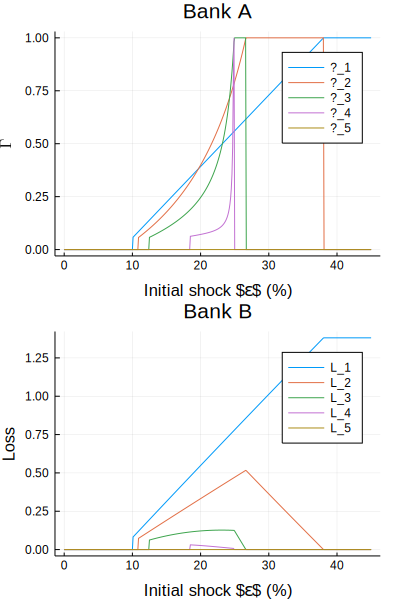

In [8]:
# simulate k rounds of deleveraging and fire sales
Γ, L, x = varyshockskrounds(k=5, figure=121)

row, col = size(Γ)

p1 = plot(x*100, Γ, xlabel=L"Initial shock $\epsilon$ (%)", ylabel=L"$\Gamma$",
            title="Bank A", label=hcat(["Γ_$(i)" for i in 1:col]...));
p2 = plot(x*100, L, xlabel=L"Initial shock $\epsilon$ (%)", ylabel="Loss",
            title="Bank B", label=hcat(["L_$(i)" for i in 1:col]...));
plot(p1,p2, layout=(2,1), size=(400, 600))

In [9]:
# Approximately 1.4 in Shaanning's thesis
print(string("L1 of Bank B: ", L[end, 1])," (should be approx 1.4 as in thesis)")

L1 of Bank B: 1.38074938434112 (should be approx 1.4 as in thesis)

## Replicate Figure 1.2.2 of Thesis

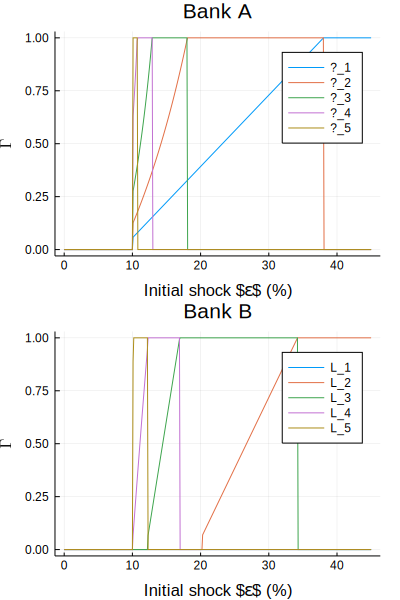

In [10]:
# simulate k rounds of deleveraging and fire sales
Γ_A, Γ_B, x = varyshockskrounds(k=5, figure=122)

row, col = size(Γ_A)

p1 = plot(x*100, Γ_A, xlabel=L"Initial shock $\epsilon$ (%)", ylabel=L"$\Gamma$",
            title="Bank A", label=hcat(["Γ_$(i)" for i in 1:col]...));
p2 = plot(x*100, Γ_B, xlabel=L"Initial shock $\epsilon$ (%)", ylabel=L"$\Gamma$",
            title="Bank B", label=hcat(["L_$(i)" for i in 1:col]...));
p = plot(p1,p2, layout=(2,1), size=(400, 600))

## Replicate Figure 1.2.4 of Thesis

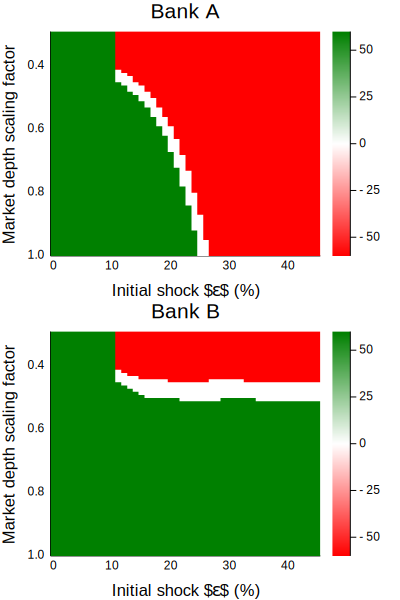

In [19]:
insolmap, xs, ys = visualizeinsolvencyilliquidity()

# green = all right, white = illiquid, red = insolvent
p1 = heatmap(xs*100, ys, insolmap[:,:,1], yflip=true,
            c=cgrad([:red,:white,:green]),
            colorbar = :right,
            grid=false,
            border=nothing,
            xlabel=L"Initial shock $\epsilon$ (%)",
            ylabel="Market depth scaling factor",
            title="Bank A");
p2 = heatmap(xs*100, ys, insolmap[:,:,2], yflip=true,
            c=cgrad([:red,:white,:green]),
            colorbar = :right,
            grid=false,
            border=nothing,
            xlabel=L"Initial shock $\epsilon$ (%)",
            ylabel="Market depth scaling factor",
            title="Bank B");
p = plot(p1,p2, layout=(2,1), size=(400, 600), dpi=100)

# Replicate the figures from Manuel Schnabel's thesis

### TODO: These plots still look different, it is however unclear if the data is the same as was used in M. Schnabel's thesis. --> Requires more debugging/investigations

In [1]:
using Pkg
# change this if the path is different
path_to_FinNetValu = "/Users/wolfgang/Desktop/Uni/HIWI/Bertschinger/SysRisk/Code/FinNetValu/"
Pkg.activate(path_to_FinNetValu)

"/Users/wolfgang/Desktop/Uni/HIWI/Bertschinger/SysRisk/Code/FinNetValu/Project.toml"

In [2]:
using FinNetValu
using DataFrames
using Missings: disallowmissing
using LaTeXStrings
using CSV
using Plots
pyplot()

Plots.PyPlotBackend()

In [3]:
# helper functions for reading and parsing csv files
"""
    disablemissing_converttoarray(a)

Takes a DataFrame object, `a`, converts it to an array and drops support for missing.
"""
function disablemissing_converttoarray(a::DataFrame)
    return disallowmissing(convert(Matrix, a))
end

"""
    parsearraytofloat(a)

Parses an array, `a`, of floats represented as strings to floats.
"""
function parsearraytofloat(a::Array)
    return map(x->tryparse(Float64, x), a)
end

"""
    load_csmatrices(C_csvpath, Π_csvpath, Θ_csvpath)

Receives the file paths to the csv files containing the information for the
C, Π and Θ matrices of the Cont and Shaanning model. The function returns these
matrices as well as string arrays containing the codes for the banks, security
assets and illiquid assets.
"""
function load_csmatrices(C_csvpath, Π_csvpath, Θ_csvpath)

    # load Capital, Pi and Theta data file
    tmpC = CSV.read(C_csvpath; header=false)
    tmpPi = CSV.read(Π_csvpath; header=false)
    tmpTheta = CSV.read(Θ_csvpath; header=false)

    # BANKING_GROUP_CODE from EBA 2011 results
    # enforcing String array representation without Missings as datatype
    bank_ids = disallowmissing(tmpPi[2:end, 1])
    # convert DataFrame object to Array, removing support for Missings
    Π_ids = vec(disablemissing_converttoarray(tmpPi[1:1, 2:end]))
    Θ_ids = vec(disablemissing_converttoarray(tmpTheta[1:1, 2:end]))

    # extract only value matrix, convert to array, remove support for Missing,
    # parse strings to floats (same for Θ)
    Π = parsearraytofloat(disablemissing_converttoarray(tmpPi[2:end, 2:end]))
    Θ = parsearraytofloat(disablemissing_converttoarray(tmpTheta[2:end, 2:end]))
    # C = parsearraytofloat(tmpC[2:end, 2])
    C = parsearraytofloat(disablemissing_converttoarray(tmpC)[2:end])

    return(C, Π, Θ, bank_ids, Π_ids, Θ_ids)
end


load_csmatrices

### The code in this block uses the data from Schnabel's R workspace sheet,"Rworkspace_before_initial_shock.RData"


In [4]:
# file paths to csv files
C_fp = "/Users/wolfgang/Desktop/Uni/HIWI/Bertschinger/SysRisk/Data/EBA_2011/MSchnabel_preprocessing/Cont_C_MSchnabel.csv"
Π_fp = "/Users/wolfgang/Desktop/Uni/HIWI/Bertschinger/SysRisk/Data/EBA_2011/MSchnabel_preprocessing/Cont_Pi_MSchnabel.csv"
Θ_fp = "/Users/wolfgang/Desktop/Uni/HIWI/Bertschinger/SysRisk/Data/EBA_2011/MSchnabel_preprocessing/Cont_Theta_MSchnabel.csv"

C, Π, Θ, bank_ids, Π_ids, Θ_ids = load_csmatrices(C_fp, Π_fp, Θ_fp);


#### German stress test scenario (Figure 1 of Schnabel's thesis), shocking German commercial and residential mortgage exposures

In [5]:
DE_bank_ids = [occursin("DE", x) for x in bank_ids]
DE_Π_ids = [occursin("DE", x) for x in Π_ids]

# commercial and residential mortgage exposures are the only illiquid asset
# class within the German market
DE_Θ_ids = [occursin("DE", x) for x in Θ_ids]
# sanity check, stress test all
# DE_Θ_ids[:] .= true

# create an array of varying shock size, only shocking german illiquid 
# assets
DE_ϵ = collect(0:0.005:.1)
ϵ_array = repeat(zeros(size(Θ_ids)), 1, size(DE_ϵ, 1))
for i in 1:size(DE_ϵ, 1)
    ϵ_array[DE_Θ_ids, i] = DE_ϵ[i]*ones(sum(DE_Θ_ids))
end

# marketdepth was 10^11 across all asset classes therefore:
τ = 1
c = 1
σ = ones(size(Π, 2))
ADV = 10^11*ones(size(Π, 2))

λ_max = 33
λ_target = 0.95*λ_max

S = ones(size(Π, 2))
B = 0.5*S

α = 0.5;

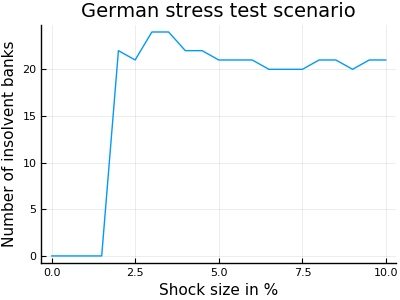

In [6]:
# test leverage of all banks
#leverage_ratio = (sum(Π, dims=2) + sum(Θ, dims=2))./C
#print(leverage_ratio)

num_insolv = ones(size(ϵ_array, 2))
for j in 1:size(ϵ_array, 2)
    csmodel = CSModel(Π, C, B, S, ADV, σ,
                            c, τ, λ_max, λ_target=λ_target, α=α, insolsell=false)
    # run fire sales cascade, store fixed point
    fp = fixvalue(csmodel, init_a(csmodel, Θ, ϵ_array[:, j]), m=0)
    num_insolv[j] = sum(.!solvent(csmodel, fp))
end

plot(DE_ϵ*100, num_insolv, xlabel="Shock size in %", ylabel="Number of insolvent banks",
            title="German stress test scenario", legend=false, size=(400,300))

#### Try to replicate Figure 5 of Schnabel's thesis, but get much less rounds of deleveraging

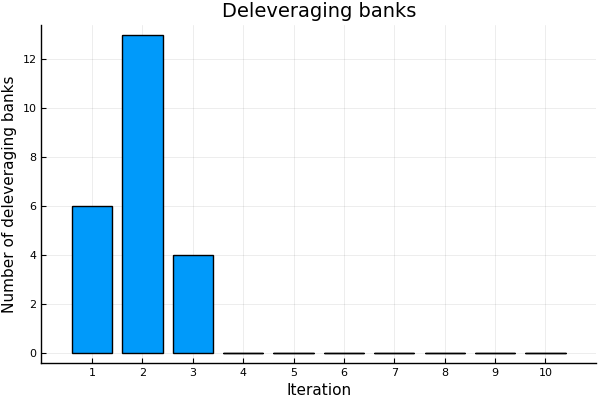

In [73]:
DE_commercial_Θ_ids = [occursin("commercial.real.estate_DE", x) for x in Θ_ids]
ϵ_array_5 = zeros(size(Θ_ids))
ϵ_array_5[DE_commercial_Θ_ids] .= 0.1

csmodel = CSModel(Π, C, B, S, ADV, σ,
                        c, τ, λ_max, λ_target=λ_target, α=α, insolsell=false)

# intial a
a = init_a(csmodel, Θ, ϵ_array_5)
# initial current state
x = FinNetValu.init(csmodel, a)

delev = zeros(10,1)
insol = zeros(10,1)
y = deepcopy(x)
for k in 1:10
    delev[k] = sum(FinNetValu.delevprop(csmodel, y, a) .> 0.0)
    insol[k] = sum(.!solvent(csmodel, y))
    valuation!(y, csmodel, y, a)
end

bar(bins=1:10, delev[:], legend=false, title="Deleveraging banks", 
    xlabel="Iteration", ylabel="Number of deleveraging banks",
    xticks=(vec(1:10)))

#### Try to replicate Figure 3 of Schnabel's thesis, warning this has a long run time!!!

In [7]:
DE_commercial_Θ_ids = [occursin("commercial.real.estate_DE", x) for x in Θ_ids]

hsbc_id = [occursin("GB089", x) for x in bank_ids]
bnp_id = [occursin("FR013", x) for x in bank_ids]

hmap = ones(10,10)

tmpC = deepcopy(C)

nsteps = 5

for bailout in 1:nsteps
    tmpC[hsbc_id] .+= bailout*(120000000000/nsteps)

    for bailout2 in 1:nsteps
        tmpC[bnp_id] .+= bailout2*(120000000000/nsteps)
        csmodel = CSModel(Π, tmpC, B, S, ADV, σ,
                            c, τ, λ_max, λ_target=λ_target, α=α, insolsell=false)
        a = init_a(csmodel, Θ, DE_commercial_Θ_ids.*0.1)
        fp = fixvalue(csmodel, a, m=0)
        sol = .!solvent(csmodel, fp)
        hmap[bailout, bailout2] = sol[hsbc_id][1] + 2*sol[bnp_id][1]
    end
end

print(hmap)


InterruptException: InterruptException: